## 11/7 Notebook to be converted to a script to run tests of mpasregions package

I think now is a good time to set up a simpler test grid as well as some units tests.
My recommendation would be a grid consisting of just 3 touching triangles or hexagons. (edited) 



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

In [3]:
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

In [4]:
lonCells = np.array([180.,  90., 270.])
latCells = np.array([-36.,  36.,  36.])

lonEdges = np.array([135., 235.,  90., 270.,  45., 135., 225., 315.,   0., 180., 45., 135., 225., 315.])
latEdges = np.array([-72., -72., -36., -36.,   0.,   0.,   0.,   0.,  36.,  36., 72.,  72.,  72.,  72.])

lonVertices = np.array([180.,  90., 270.,  90., 270.,   0., 180.,   0., 180., 90., 270.])
latVertices = np.array([-90., -54., -54., -18., -18.,  18.,  18.,  54.,  54., 90.,  90.])

ds = xr.Dataset({},coords={
    'nCells':xr.DataArray(np.arange(0,len(lonCells)), dims='nCells'),
    'nEdges': xr.DataArray(np.arange(0,len(lonEdges)), dims='nEdges'),
    'nVertices':xr.DataArray(np.arange(0,len(lonVertices)), dims='nVertices')
})

ds['lonCell'] = xr.DataArray(np.deg2rad(lonCells), dims='nCells')
ds['latCell'] = xr.DataArray(np.deg2rad(latCells), dims='nCells')
ds['lonEdge'] = xr.DataArray(np.deg2rad(lonEdges), dims='nEdges')
ds['latEdge'] = xr.DataArray(np.deg2rad(latEdges), dims='nEdges')
ds['lonVertex'] = xr.DataArray(np.deg2rad(lonVertices), dims='nVertices')
ds['latVertex'] = xr.DataArray(np.deg2rad(latVertices), dims='nVertices')

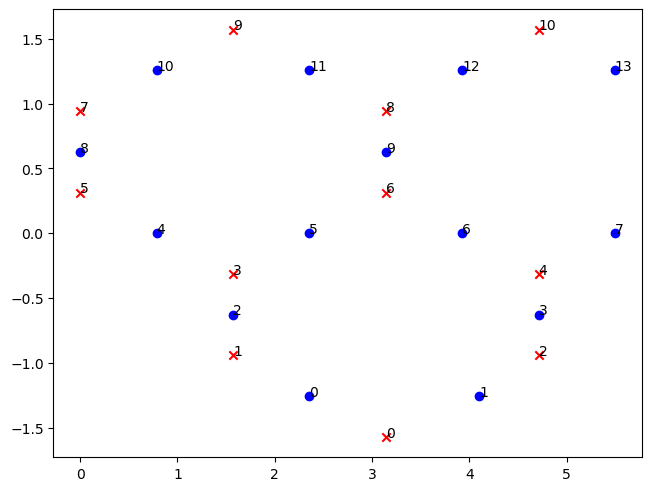

In [5]:
fig,ax=plt.subplots(nrows=1,ncols=1,constrained_layout=True)
ax.scatter(ds.lonEdge, ds.latEdge,color='blue')
ax.scatter(ds.lonVertex,ds.latVertex,marker='x',color='red')
nEdges = ds.nEdges.values
nVertices = ds.nVertices.values

for i, txt in enumerate(nEdges):
    ax.annotate(txt, (ds.lonEdge[i],ds.latEdge[i]))

for i, txt in enumerate(nVertices):
    ax.annotate(txt, (ds.lonVertex[i], ds.latVertex[i]))

In [7]:
xr_edgesOnVertex =  np.array([
    [0,1,np.nan], # on vertex 0
    [0,2,np.nan], # on vertex 1
    [1,3,np.nan], # on vertex 2
    [2,4,5], # on vertex 3
    [3,6,7], # on vertex 4
    [4,7,8], # on vertex 5
    [5,6,9], # on vertex 6
    [8,10,13], # on vertex 7
    [9,11,12], # on vertex 8
    [10,11,np.nan], # on vertex 9
    [12,13,np.nan] # on vertex 10
])

n_edgesOnVertex = mps.xr_to_n_idx(xr_edgesOnVertex)
n_edgesOnVertex[np.isnan(n_edgesOnVertex)] = 0 # extra vertices that were once nans are now zeros

ds['edgesOnVertex'] = xr.DataArray(np.int32(n_edgesOnVertex), dims = ('nVertices','vertexDegree'))

In [8]:
xr_verticesOnEdge = np.array([
    [0,1], # on edge 0
    [0,2], # on edge 1
    [1,3], # on edge 2
    [2,4], # on edge 3
    [3,5], # on edge 4
    [3,6], # on edge 5
    [4,6], # on edge 6
    [4,5], # on edge 7
    [5,7], # on edge 8
    [6,8], # on edge 9
    [7,9], # on edge 10
    [8,9], # on edge 11
    [8,10], # on edge 12
    [7,10] # on edge 13
    
])

n_verticesOnEdge = mps.xr_to_n_idx(xr_verticesOnEdge)
ds['verticesOnEdge'] = xr.DataArray(np.int32(n_verticesOnEdge), dims=('nEdges', 'TWO'))

In [9]:
ds['VertexID'] = mps.xr_to_n_idx(ds.nVertices)
ds = ds.assign_coords({'VertexID': mps.xr_to_n_idx(ds.nVertices)})
ds

<xarray.Dataset> Size: 1kB
Dimensions:         (nCells: 3, nEdges: 14, nVertices: 11, vertexDegree: 3,
                     TWO: 2)
Coordinates:
  * nCells          (nCells) int64 24B 0 1 2
  * nEdges          (nEdges) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * nVertices       (nVertices) int64 88B 0 1 2 3 4 5 6 7 8 9 10
    VertexID        (nVertices) int64 88B 1 2 3 4 5 6 7 8 9 10 11
Dimensions without coordinates: vertexDegree, TWO
Data variables:
    lonCell         (nCells) float64 24B 3.142 1.571 4.712
    latCell         (nCells) float64 24B -0.6283 0.6283 0.6283
    lonEdge         (nEdges) float64 112B 2.356 4.102 1.571 ... 3.927 5.498
    latEdge         (nEdges) float64 112B -1.257 -1.257 -0.6283 ... 1.257 1.257
    lonVertex       (nVertices) float64 88B 3.142 1.571 4.712 ... 1.571 4.712
    latVertex       (nVertices) float64 88B -1.571 -0.9425 ... 1.571 1.571
    edgesOnVertex   (nVertices, vertexDegree) int32 132B 1 2 0 1 3 ... 0 13 14 0
    verticesOnEdge  (nEdges, TWO) int32 112B 1 2 1 3 2 4 3 ... 10 9 10 9 11 8 11

In [12]:
target_start_lon, target_start_lat = 0, 18
target_end_lon, target_end_lat = 180, 18

In [13]:
# # function to calculate transect given a target start point, target end point, and ds
# # def calculate_transects(target_start_lat, target_start_lon, target_end_lat, target_end_lon, ds):
# # ---------- INITIATE START VERTEX ----------------
# # of these transect cells, select the one that is closest to the desired starting point.
# # desired values in deg
# # distance_on_unit_sphere(lon1, lat1, lon2, lat 2)
# # find the shortest path between the two points
# # of all of the points, find the vertex that is closest to the desired start point
# dist_to_start = mps.distance_on_unit_sphere(ds.lonVertex * 180/np.pi, ds.latVertex * 180/np.pi, target_start_lon, target_start_lat)
# xr_start_vertex = dist_to_start.argmin()
# ### print('very first start vertex is ', np.int32(xr_start_vertex))
# n_start_vertex = mps.xr_to_n_idx(xr_start_vertex)

# start_lon = ds.isel(nVertices = xr_start_vertex).lonVertex * 180/np.pi
# start_lat = ds.isel(nVertices = xr_start_vertex).latVertex * 180/np.pi

# # repeat to find the vertex that is closest to the desired end point
# dist_to_end = mps.distance_on_unit_sphere(ds.lonVertex * 180/np.pi, ds.latVertex * 180/np.pi, target_end_lon, target_end_lat)

# # get the vertex closest to the target end lat and lon
# xr_end_vertex = dist_to_end.argmin()
# ### print('xr_end_vertex is ', np.int32(xr_end_vertex))
# end_lon = ds.isel(nVertices = xr_end_vertex).lonVertex * 180/np.pi
# end_lat = ds.isel(nVertices = xr_end_vertex).latVertex * 180/np.pi

# # get an array of the start and end points (this is useful if transects are broken up by land)
# xr_start_end_vertices = np.array([xr_start_vertex, xr_end_vertex])

# # get distance between target start point and target end point
# distance = mps.distance_on_unit_sphere(start_lon, start_lat, target_end_lon, target_end_lat)

# # ---------- FIND NEXT VERTEX ----------------
# start_vertices = np.array([])
# next_vertices = np.array([])

# count=0

# while distance.min() > 10: #10000:
#     count += 1
#     ### print(count)
#     # get the edges attached to the start vertex
#     n_edgesOnStartVertex = ds.edgesOnVertex.isel(nVertices = xr_start_vertex)
#     xr_edgesOnStartVertex = mps.n_to_xr_idx(n_edgesOnStartVertex)
#     ### print('edges attached to start vertex ', np.int32(xr_start_vertex), ' are ', xr_edgesOnStartVertex)
    
#     # check that the edges you selected are connected to the start vertex (returns in n indices)
#     # ds.verticesOnEdge.isel(nEdges = xr_edgesOnStartVertex[0])
    
#     # for each of these edges, find the vertices they are connected to and then remove the start_vertex (we don't want to "travel back" to that vertex)
#     n_vertices_nextToStartVertex = np.unique(ds.verticesOnEdge.isel(nEdges = np.int32(xr_edgesOnStartVertex)))
#     xr_vertices_nextToStartVertex = mps.n_to_xr_idx(n_vertices_nextToStartVertex)
#     # print(xr_vertices_nextToStartVertex)
#     print('possible vertices to move to are ', xr_vertices_nextToStartVertex)

#     used_vertices = np.union1d(start_vertices, xr_start_vertex)
    
#     xr_vertices_nextToStartVertex_Use = np.delete(xr_vertices_nextToStartVertex, np.where(np.isin(xr_vertices_nextToStartVertex, used_vertices)))
#     ### print('excluding the start vertex, the next vertices we can move to are' , xr_vertices_nextToStartVertex_Use)
#     # print(xr_vertices_nextToStartVertex_Use)
#     # calculate the distance from these new vertices to the desired end point
#         # retrieve the lat and lon of the vertex
#     # ds_vertices_nextLatLon = ds[['lonVertex','latVertex']].where(ds.nVertices.isin(xr_vertices_nextToStartVertex_Use))
#     ds_vertices_nextLatLon = ds[['lonVertex','latVertex']].isel(nVertices = xr_vertices_nextToStartVertex_Use)
#     ds_vertices_nextLatLon['lonVertex'] = ds_vertices_nextLatLon.lonVertex * 180/np.pi
#     ds_vertices_nextLatLon['latVertex'] = ds_vertices_nextLatLon.latVertex * 180/np.pi
    
#     # calculate the distance between the next vertices and the target end
#     distance = mps.distance_on_unit_sphere(ds_vertices_nextLatLon.lonVertex, ds_vertices_nextLatLon.latVertex, target_end_lon, target_end_lat)
    
#     # select the nVertex that is the shortest distance from the end point
#     chosen_nextVertex_arg = distance.argmin()
#     n_chosen_nextVertex = distance.VertexID[chosen_nextVertex_arg]
#     xr_chosen_nextVertex = mps.n_to_xr_idx(n_chosen_nextVertex)
#     print('the chosen next vertex to move to is ', np.int32(xr_chosen_nextVertex))
    
#     # ---------- UPDATE ARRAYS ----------------
    
#     # store vertices
#     start_vertices = np.append(start_vertices, xr_start_vertex)
#     next_vertices = np.append(next_vertices, xr_chosen_nextVertex)

#     xr_start_vertex = xr_chosen_nextVertex 

#     # break code if the next vertex is the vertex closest to the target end lat and lon
#     if xr_chosen_nextVertex == xr_end_vertex:
#         print('broken because reached end vertex')
#         break

# # ---------- FIND EDGES OF TRANSECT ---------------- 
# # We want to identify the edges that connect the vertices. The vertices are already ordered consecutively (because the transects are built from an algorithm)
# # We will take advantage of this fact using a for loop to extract the edges that are shared between vertices next to each other

# # modify next_vertices to also include the start vertex
# next_vertices = np.insert(next_vertices, 0, mps.n_to_xr_idx(n_start_vertex))


# # next vertices are in xr indices
# int_next_vertices = np.int32(next_vertices)
# n_transect_edges = np.array([])

# for i in range(0,len(int_next_vertices)-1):
#     edgesOnVertex0 = ds.edgesOnVertex.isel(nVertices = int_next_vertices[i]).values
#     edgesOnVertex1 = ds.edgesOnVertex.isel(nVertices = int_next_vertices[i+1]).values
#     shared_edge = np.intersect1d(edgesOnVertex0, edgesOnVertex1)
#     n_transect_edges = np.append(n_transect_edges, shared_edge)

# xr_transect_edges = mps.n_to_xr_idx(n_transect_edges)

    
# # return xr_transect_edges, next_vertices

possible vertices to move to are  [3 4 5 7]
the chosen next vertex to move to is  3
possible vertices to move to are  [1 3 5 6]
the chosen next vertex to move to is  6
broken because reached end vertex


In [22]:
# test transect algorithm
def test_calculate_transects(ds):
    from mpasregions.sections import calculate_transects
    test_edges, test_vertices = calculate_transects(-30, 90, 60, 180, ds)
    return test_edges, test_vertices

In [18]:
# def calculate_transects(target_start_lat, target_start_lon, target_end_lat, target_end_lon, ds):

xr_transect_edges, next_vertices = mps.calculate_transects(target_start_lat, target_start_lon, target_end_lat, target_end_lon, ds)

broken because reached end vertex


broken because reached end vertex


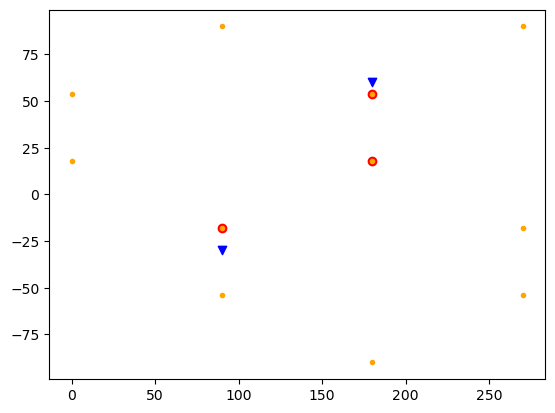

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1)

test_edges, test_vertices = test_calculate_transects(ds)
nv_lons_deg = np.rad2deg(ds.lonVertex.isel(nVertices = np.int32(test_vertices)))
nv_lats_deg = np.rad2deg(ds.latVertex.isel(nVertices = np.int32(test_vertices)))

ax.scatter(nv_lons_deg, nv_lats_deg, label = 'calculate_transects', color='red')

ax.scatter(np.array([90, 180]), np.array([-30, 60]), label='target start and end',color='blue',marker='v')

ax.scatter(np.rad2deg(ds.lonVertex), np.rad2deg(ds.latVertex), marker='.', label = 'Vertex points',color='orange')
#ax.legend()

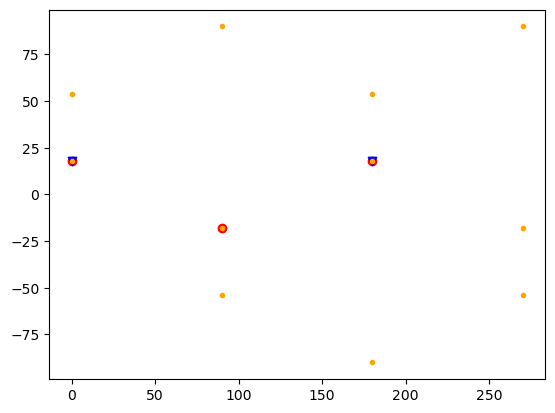

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1)

nv_lons_deg = np.rad2deg(ds.lonVertex.isel(nVertices = np.int32(next_vertices)))
nv_lats_deg = np.rad2deg(ds.latVertex.isel(nVertices = np.int32(next_vertices)))

ax.scatter(nv_lons_deg, nv_lats_deg, label = 'calculate_transects', color='red')

ax.scatter(np.array([target_start_lon, target_end_lon]), np.array([target_start_lat, target_end_lat]), label='target start and end',color='blue',marker='v')

ax.scatter(np.rad2deg(ds.lonVertex), np.rad2deg(ds.latVertex), marker='.', label = 'Vertex points',color='orange')
#ax.legend()

In [20]:
next_vertices

array([5., 3., 6.])

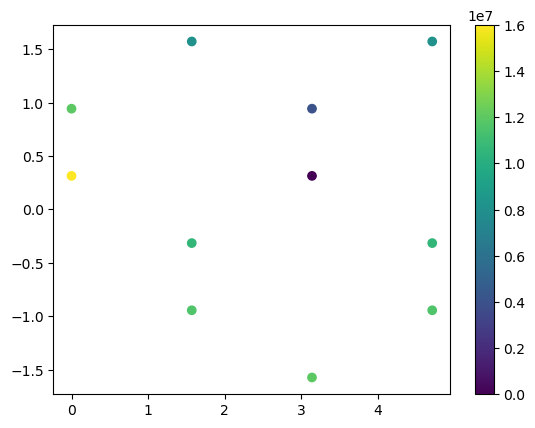

In [21]:
plt.scatter(ds.lonVertex, ds.latVertex,c=dist_to_end)
plt.colorbar()